## Regression as optimization problems
Linear regression and many other model fitting problems can be viewed mathematically as solutions to optimization problems.  We’ll explore how this can help generalize our models as well as how we can introduce regularization to emphasize fitting models with special properties.
### An outline of today:
1. Linear regression as an optimization problem
    - Loss functions
2. Curve fitting as optimization
3. Is a perfect fit actually perfect? (wacky zero loss examples)
4. Model regularization
    - Small weights
    - Sparsity

## 1. Linear regression
In linear regression, we seek to find a linear model that explains our data.  If our data is a single independent variable and a single dependent variable, this looks like finding a line that most closely passes through a set of points.

In [18]:
#Importing libraries. The same will be used throughout the lesson.
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 10
from ipywidgets import interactive
from ipywidgets import IntSlider

# 1-D linear models
$$y_{\mathrm{predicted}}=\mathrm{(Slope)}\cdot x + \mathrm{(y\ intercept)}$$
The above is the equation for a one dimensional linear model.
One way to measure the performance of such a model is to see what the residuals or error looks like.
The residuals are the answer to the question *what's the difference between the model's predicted outputs and the actual observed outputs?*
Mathematically, this is expressed as 

$$\mathrm{total\ error}(y,\ y_{\mathrm{predicted}}) = \sum_{\text{data points }x} \big|(\text{Observed output }y\text{ at input }x) - (\text{Model prediction }y_{\mathrm{predicted}}\text{ at input }x) \big|$$

### Run the next code block and use the sliders in its output to see how tweaking the two parameters affects the residuals we see!

In [19]:
# Define data as the points separted by 0.5 in the input going from 0 to 10, and output y=x
# input values: x
x = np.array([i*.5 for i in range(0,21)]) 
# output observations: y = 4x + 3 + noise (underlying "true" model is y=4x+3)
y = 4*x + 3 + np.random.normal(0,0.3,len(x)) 

def linear_model_1d(slope, y_intercept):
    plt.figure(2)
    # plot the linear model
    y_pred = slope * x + y_intercept
    model = plt.plot(x, y_pred)
    
    # plot the errors between actual observations and model with given parameters
    errs = sum(np.abs(y_pred-y))
    sq_errs = sum((y_pred-y)**2)
    for i in range(len(x)):
        plt.plot([x[i],x[i]],[y[i],y_pred[i]],'r--') 
    # plot the actual observations
    plt.plot(x,y,'.',markersize=20)
    plt.ylim( np.floor(np.min(y)-1), np.ceil(np.max(y)+1))
    plt.xlim( np.floor(np.min(x)-1), np.ceil(np.max(x)+1))
    plt.title('total error (residual)= {:5.3f}\n squared error (rss)= {:5.3f}'.format(errs,sq_errs))
    plt.show()
interactive_plot = interactive(linear_model_1d, slope=(-5, 10), y_intercept=(np.floor(np.min(y))-2, np.ceil(np.max(y)/2),1))
output = interactive_plot.children[-1]
interactive_plot

interactive(children=(IntSlider(value=2, description='slope', max=10, min=-5), FloatSlider(value=11.0, descrip…

As you can see above, there are lots of choices for even just two parameters (slope and y-intercept), and they drastically affect the error depending on how they're picked. 

## So how do we actually pick the best parameters when doing regression?
One way to define the *"best"* model is that it's the model which has the least error or *loss*. 
The act of finding which model parameters result in the least error is called *optimization*.
$$\text{(Best model) solves}\ \ \text{min }loss$$
More generally, optimization is the task of finding the **minimum or maximum** of some **function**, typically called the *objective* or *loss*.
Here, we'll be focussing on when the loss somehow **expresses the (in)accuracy of our model's predictions**.
For example, when the function is the residuals given model parameters, and we want to minimize the residuals.

The typical function of the residuals used for linear regression to fit lines is given by
$$\mathrm{squared\ error}(y,\ y_{\mathrm{predicted}}) = \sum_{\text{data points }x} \big((\text{Observed output }y\text{ at input }x) - (\text{Model prediction }y_{\mathrm{predicted}}\text{ at input }x) \big)^2$$
The reason for **squaring** instead of absolute value as before is mathematically it makes things easier to optimize. infact it allows for an explicit equation for the optimal parameters.
For this reason, sometimes linear regression is called ***Least squares.***

**Run the below code block to see the best fit line. Notice how its squared error is smaller than (or equal to) that of the model no matter how you tweak the slope and y-intercept** (there's a lot of code there, but most of it is for making interactive plots and graphics later.  It's not necessary to read and understand it)

Best fit linear model: y = 4.012 x  +  2.868


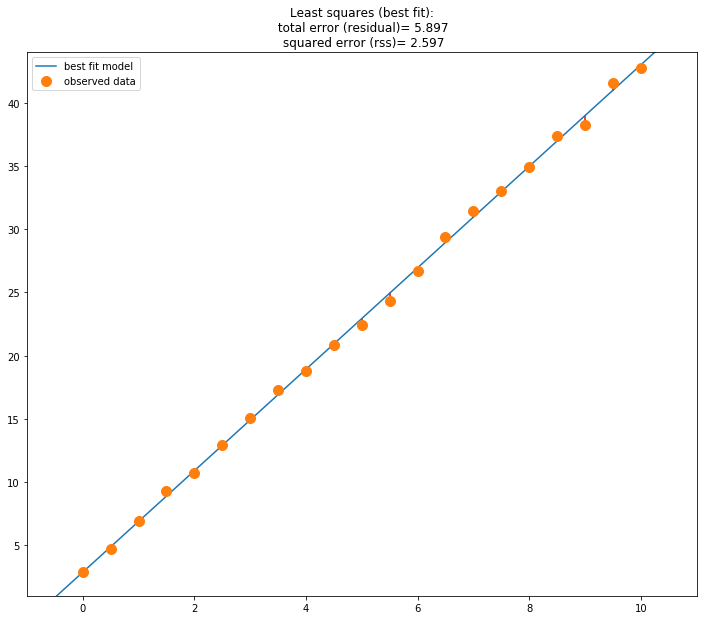

In [20]:
#Import Linear Regression model from scikit-learn.
from sklearn.linear_model import LinearRegression
data = pd.DataFrame(np.column_stack([x,y]),columns=['x','y'])
# below is actually implementation of polynomial regression
for i in range(2,41):  #power of 1 is already there
    colname = 'x^%d'%i      #new var will be x_power
    data[colname] = data['x']**i
def p_regression(data, power):
    #initialize predictors:
    predictors=['x']
    if power>=2:
        predictors.extend(['x^%d'%i for i in range(2,power+1)])
    
    # define domain to plot a finer model than given input data points
    pltx = np.linspace(np.min(x-1), np.max(x+1), 300, endpoint=True)
    pltdata = pd.DataFrame(np.column_stack([pltx]),columns=['x'])
    for i in range(2,power+1):  #power of 1 is already there
        colname = 'x^%d'%i      #new var will be x_power
        pltdata[colname] = pltdata['x']**i
        
    #Fit the model
    linreg = LinearRegression(normalize=True)
    linreg.fit(data[predictors],data['y'])
    y_pred = linreg.predict(data[predictors])
    plt_pred = linreg.predict(pltdata[predictors])
    
    # compute errors (loss)
    sq_errs_ls = sum((y_pred-data['y'])**2)
    errs_ls = sum(np.abs(y_pred-data['y']))
    
    # plt.tight_layout()
    for i in range(len(x)):
        plt.plot([x[i],x[i]],[y[i],y_pred[i]],'r-') 
    model, =plt.plot(pltx,plt_pred,label='best fit model')
    obs,   =plt.plot(data['x'],data['y'],'.',markersize=20,label='observed data')
    plt.title('Least squares (best fit):\n total error (residual)= {:5.3f}\n squared error (rss)= {:5.3f}'.format(errs_ls,sq_errs_ls))    
    plt.ylim( np.floor(np.min(y)-1), np.ceil(np.max(y)+1))
    plt.xlim( np.floor(np.min(x-1)), np.ceil(np.max(x+1)))
    plt.legend([model,obs],['best fit model','observed data'])
    #Return the result in pre-defined format
    ret = [sq_errs_ls]
    ret.extend([errs_ls])
    ret.extend([linreg.intercept_])
    ret.extend(linreg.coef_)
    return ret
model_coefs = p_regression(data, power=1)
print('Best fit linear model: y = {:5.3f} x  +  {:5.3f}'.format(model_coefs[3],model_coefs[2]))

In [21]:
# THIS WHOLE CELL CAN BE IGNORED;
# It shows the explicit expression in terms of the data for the optimal solution of least squares using linear algebra
from numpy.linalg import inv
"""
 Mathematically the explicit solution for general least squares linear regression 
 can be expressed with matrices and vectors as follows.
 Let X denote the matrix of inputs x_1...x_n with an extra row of 1s under the input vectors.
 Then w are the weights of each input variable including the bias (which is the extra row of 1s. 
 The predicted value y for some input x is then (w^T)x where ^T denotes the transpose of the weight vector w.
 The optimal choice of w is explicitly given as w = (X^T * X)^(-1) * X^T y
 In the 1-d case, w's first component is optimal slope and second component is optimal intercept.
"""
a = x.reshape(len(x),1)
b = np.ones((len(x),1))
xx = np.column_stack((a, b))
#  w =      (X^T * X)^(-1)   *     (X^T)*y
w = inv((xx.transpose()@xx)) @ (xx.transpose())@y
print(w)

[4.01249467 2.86768014]


# Optimization for curve fitting
### Notice that in the earlier formula for squared error, there's nothing forcing $y_{\mathrm{predicted}}$ to be linear!
We can use the same idea as linear regression to fit just about any model we want to our data.

For some families of models (e.g. including linear models), there are explicit equations which express the best model parameters (here the values for slope and $y$-intercept) explicitly in terms of our data.

For other families of models there's not always a simple solution.  Usually, this isn't an issue. There are many algorithms for optimization that find good models, even if the perfect choice can't be expressed easily as an equation. Two popular examples are *Gradient descent* and *Newton's method*.

It's not actually necessary to know these algorithms or how to impliment them in order to do optimization though.  
Languages like Python and R and Julia have packages built in that allow you to use implimentations that experts have already done the work to create!

**Run the code block below to run regression where $y_{\mathrm{predicted}}$ is a polynomial of the input variable x with degree up to "power". Play around with the "power" slider and see what happens to error**

In [22]:
def poly_reg(power):
    model_coeff=p_regression(data,power)
    return model_coeff
interactive_plot = interactive(poly_reg, power=IntSlider(min=1, max=40, step=1, value=1))
output = interactive_plot.children[-1]
interactive_plot

interactive(children=(IntSlider(value=1, description='power', max=40, min=1), Output()), _dom_classes=('widget…

### Run the below code block to try the same thing with a less linear  set of data
What would you say the best choice of powers are to model these data sets polynomially?
**Are they given by the smallest error? Why or why not?**

In [23]:
# Define nonlinear data and plot polynomial regression interactively
x = np.array([i*np.pi/180 for i in range(150,2*360,8)])
y = 2*(np.sin(x/2) + np.random.normal(0,0.1,len(x)))+.5*(np.sin(x**2))
data = pd.DataFrame(np.column_stack([x,y]),columns=['x','y'])
for i in range(2,41):  #power of 1 is already there
    colname = 'x^%d'%i      #new var will be x_power
    data[colname] = data['x']**i
interactive_plot = interactive(poly_reg, power=IntSlider(min=1, max=40, step=1, value=1))
output = interactive_plot.children[-1]
interactive_plot

interactive(children=(IntSlider(value=1, description='power', max=40, min=1), Output()), _dom_classes=('widget…

In [24]:
# run this to see what we're running linear regression on. It'll output five points from our data set as rows:
# Note it's no longer just input x and output y, 
# but input x along with x^2, x^3, x^4, ..., x^40 and output y
data.head()

,x,y,x^2,x^3,x^4,x^5,x^6,x^7,x^8,x^9,...,x^31,x^32,x^33,x^34,x^35,x^36,x^37,x^38,x^39,x^40
0,2.6,1.9,6.9,18,47,1.2e+02,3.2e+02,8.4e+02,2.2e+03,5.8e+03,...,9.1e+12,2.4e+13,6.2e+13,1.6e+14,4.3e+14,1.1e+15,2.9e+15,7.6e+15,2e+16,5.2e+16
1,2.8,2.8,7.6,21,58,1.6e+02,4.4e+02,1.2e+03,3.3e+03,9.2e+03,...,4.5e+13,1.3e+14,3.4e+14,9.5e+14,2.6e+15,7.2e+15,2e+16,5.5e+16,1.5e+17,4.2e+17
2,2.9,2.4,8.4,24,70,2e+02,5.9e+02,1.7e+03,5e+03,1.4e+04,...,2.1e+14,6.1e+14,1.8e+15,5.1e+15,1.5e+16,4.3e+16,1.2e+17,3.6e+17,1e+18,3e+18
3,3,2.2,9.2,28,85,2.6e+02,7.8e+02,2.4e+03,7.2e+03,2.2e+04,...,9e+14,2.7e+15,8.3e+15,2.5e+16,7.7e+16,2.3e+17,7.1e+17,2.1e+18,6.5e+18,2e+19
4,3.2,2,10,32,1e+02,3.2e+02,1e+03,3.3e+03,1e+04,3.3e+04,...,3.6e+15,1.2e+16,3.7e+16,1.2e+17,3.7e+17,1.2e+18,3.7e+18,1.2e+19,3.8e+19,1.2e+20


## Run the next two code blocks below to see a static side-by-side comparison of various polynomial models, including an explicit look at the model weights.

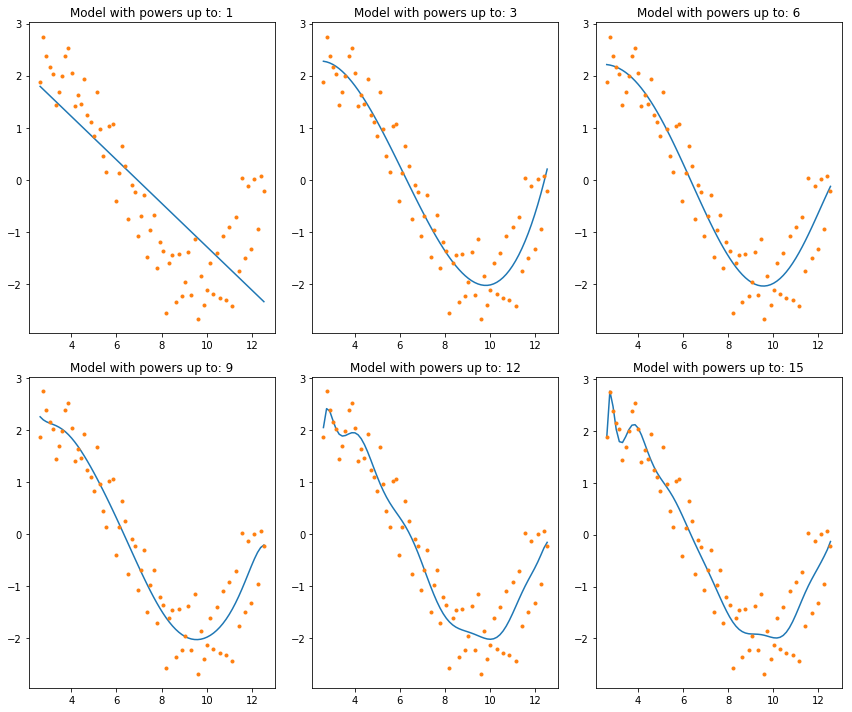

In [25]:
#Import Linear Regression model from scikit-learn.
def p_regression2(data, power, models_to_plot):
    #initialize predictors:
    predictors=['x']
    if power>=2:
        predictors.extend(['x^%d'%i for i in range(2,power+1)])
    
    #Fit the model
    linreg = LinearRegression(normalize=True)
    linreg.fit(data[predictors],data['y'])
    y_pred = linreg.predict(data[predictors])
    
    #Check if a plot is to be made for the entered power
    if power in models_to_plot:
        plt.subplot(models_to_plot[power])
        plt.tight_layout()
        plt.plot(data['x'],y_pred)
        plt.plot(data['x'],data['y'],'.')
        plt.title('Model with powers up to: %d'%power)
    
    #Return the result in pre-defined format
    sq_error = sum((y_pred-data['y'])**2)
    ret = [sq_error]
    ret.extend([linreg.intercept_])
    ret.extend(linreg.coef_)
    return ret

#Initialize a dataframe to store the results:
col = ['sq_error','intercept','coef_x'] + ['coef_x^%d'%i for i in range(2,16)]
ind = ['model_pow_%d'%i for i in range(1,16)]
coef_matrix_simple = pd.DataFrame(index=ind, columns=col)

#Define the powers for which a plot is required:
models_to_plot = {1:231,3:232,6:233,9:234,12:235,15:236}

#Iterate through all powers and assimilate results
for i in range(1,16):
    coef_matrix_simple.iloc[i-1,0:i+2] = p_regression2(data, power=i, models_to_plot=models_to_plot)

In [26]:
    #Set the display format to be scientific for ease of analysis
pd.options.display.float_format = '{:,.2g}'.format
coef_matrix_simple

,sq_error,intercept,coef_x,coef_x^2,coef_x^3,coef_x^4,coef_x^5,coef_x^6,coef_x^7,coef_x^8,coef_x^9,coef_x^10,coef_x^11,coef_x^12,coef_x^13,coef_x^14,coef_x^15
model_pow_1,66,2.9,-0.42,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
model_pow_2,30,7.5,-1.8,0.094,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
model_pow_3,17,0.4,1.6,-0.41,0.022,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
model_pow_4,17,-2.7,3.7,-0.89,0.067,-0.0015,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
model_pow_5,16,3,-1.1,0.63,-0.16,0.014,-0.00041,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
model_pow_6,16,1.8,0.096,0.15,-0.06,0.0036,0.00016,-1.3e-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
model_pow_7,16,10,-9.8,5,-1.3,0.19,-0.016,0.0007,-1.4e-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
model_pow_8,16,-3.6,8.9,-5.8,2.1,-0.45,0.059,-0.0046,0.00019,-3.4e-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN
model_pow_9,16,79,-1.2e+02,80,-30,6.9,-1,0.1,-0.006,0.00021,-3.1e-06,NaN,NaN,NaN,NaN,NaN,NaN
model_pow_10,16,2.1e+02,-3.4e+02,2.4e+02,-1e+02,26,-4.5,0.52,-0.041,0.002,-5.7e-05,7.1e-07,NaN,NaN,NaN,NaN,NaN


As you might notice looking at the table of values above, the higher one allows the power for a polynomial model to be, the lower the resulting (squared) error of the model on our data set.  
On the other hand from the pictures it seems like something like a power 3 model might most fit our data set.  
Higher powers than that start to just fit noise and had excessive wigglyness.
With arbitrary data, we can't know the what a good power or choice of model will be in advance.
But we can notice a trend above. The higher powers we allow, the higher the weights overall.  These high weights and soemtimes the fact that we have many weights whichare nonzero might be what most contribute to the wiggliness of our model.
That is, having high model weights and many mnay weights seem to allow the model to fit extra noise in addition to the underlying signal generating the data.
# Regularization
It would be nice if we had some way of telling the computer that we'd prefer a model that fit less noise or had less extra wiggliness.
One common method of conveying this sort of priority is with **regularization**.
Instead of just trying to find the model that minimizaes some error, we can add some preference we have as a modeller.  
Two common preferences are 
- small model weights
- only a few model weights nonzero (this is called sparsity).
If we want to find a model with these we can still just solve an optimization problem.
Instead of 
$$\min_{\text{possible models}} \mathrm{(Error)},$$
where error is some expression of differences of input and output predicted by a possible model,
we now solve something like
$$\min_{\text{possible models}}\hspace{3em} \mathrm{(Error)}\hspace{1.5em}+ \underbrace{\lambda\cdot\sum_{\mathrm{weights}}(\mathrm{model\ weight})^2}_{\substack{\lambda\text{ is a coefficient denoting how penalized high model weights are}}}$$
The extra term we add in adition to error in our objective is called the **regularizer** or **regularization term**
Solving the above optimization problem finds a model which has **small error** *and* **small model weights**.
There's often a tradeoff between these two, and sometimes only one of them can actually be very small.
Choosing $\lambda$ is how one specifies their preference in this tradeoff.  
- A very **high value of $\lambda$** says that we think the "best" model should mostly care about having **small weights and ignore the error**.  
- A very **low value of $\lambda$** says that we think the "best" model should mostly care about having **small error and ignore the weigths**.
This sort of regularization has many names and is called *"Ridge regression"*, *"$L^2$ regularization*, *$\ell^2$ regularization*.

**Run the code block below to see it in action on the same data**

In [27]:
#Import Linear Regression model from scikit-learn.
from sklearn.linear_model import Ridge
def rid_regression(data, power,regularization_wt):
    #initialize predictors:
    predictors=['x']
    if power>=2:
        predictors.extend(['x^%d'%i for i in range(2,power+1)])
    
    # define domain to plot a finer model than given input data points
    pltx = np.linspace(np.min(x-1), np.max(x+1), 300, endpoint=True)
    pltdata = pd.DataFrame(np.column_stack([pltx]),columns=['x'])
    for i in range(2,power+1):  #power of 1 is already there
        colname = 'x^%d'%i      #new var will be x_power
        pltdata[colname] = pltdata['x']**i
        
    #Fit the model
    ridreg = Ridge(alpha=regularization_wt,normalize=True)
    ridreg.fit(data[predictors],data['y'])
    y_pred = ridreg.predict(data[predictors])
    plt_pred = ridreg.predict(pltdata[predictors])
    
    # compute errors (loss)
    sq_errs_ls = sum((y_pred-data['y'])**2)
    errs_ls = sum(np.abs(y_pred-data['y']))
    
    # plt.tight_layout()
    for i in range(len(x)):
        plt.plot([x[i],x[i]],[y[i],y_pred[i]],'r-') 
    model, =plt.plot(pltx,plt_pred,label='best fit model')
    obs,   =plt.plot(data['x'],data['y'],'.',markersize=20,label='observed data')
    plt.title('Lambda={:.3g}\nLeast squares (best fit):\n total error (residual)= {:5.3f}\n squared error (rss)= {:5.3f}'.format(regularization_wt,errs_ls,sq_errs_ls))    
    plt.ylim( np.floor(np.min(y)-1), np.ceil(np.max(y)+1))
    plt.xlim( np.floor(np.min(x-1)), np.ceil(np.max(x+1)))
    plt.legend([model,obs],['best fit model','observed data'])
    sq_error = sum((y_pred-data['y'])**2)
def rr(lam_expnt):
    rid_regression(data,15,10**(lam_expnt))
int_plot = interactive(rr,lam_expnt=IntSlider(min=-20,max=4,step=1, value=-20))
output = int_plot.children[-1]
int_plot

interactive(children=(IntSlider(value=-20, description='lam_expnt', max=4, min=-20), Output()), _dom_classes=(…

## Run the next two code blocks below to see a static side-by-side comparison of various values for $\lambda$, including an explicit look at the model weights it induces.  
### Notice that overall, the weights are much smaller than before and that the models generated look much smoother. (there's less extra wiggling to fit noise).

/nobackup/software/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:112: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number4.369088e-17
  overwrite_a=True).T


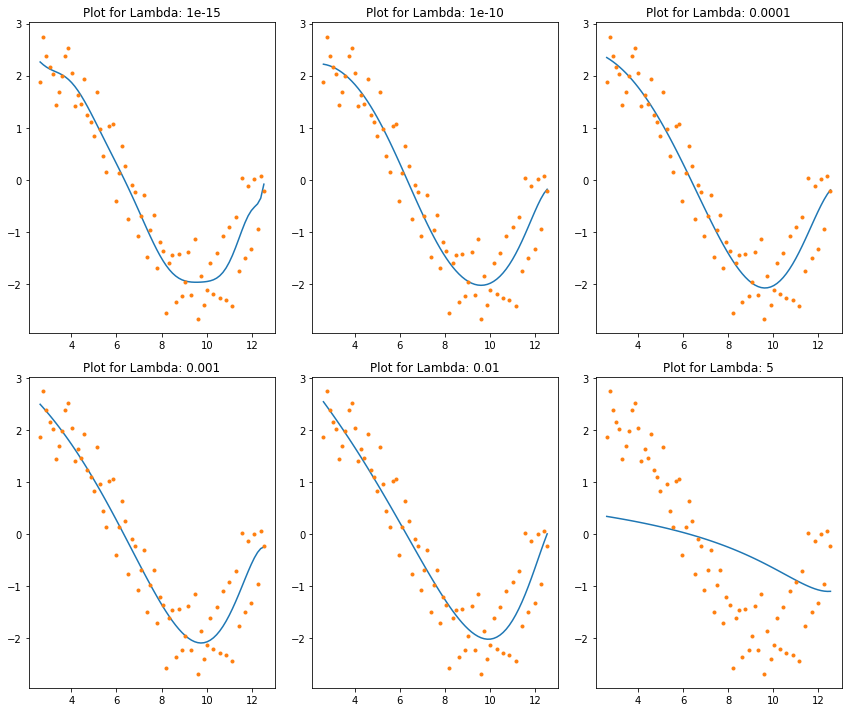

In [28]:
def ridge_regression(data, predictors, regularization_wt, models_to_plot={}):
    #Fit the model
    ridgereg = Ridge(alpha=regularization_wt,normalize=True)
    ridgereg.fit(data[predictors],data['y'])
    y_pred = ridgereg.predict(data[predictors])
    
    #Check if a plot is to be made for the entered alpha
    if regularization_wt in models_to_plot:
        plt.subplot(models_to_plot[regularization_wt])
        plt.tight_layout()
        plt.plot(data['x'],y_pred)
        plt.plot(data['x'],data['y'],'.')
        plt.title('Plot for Lambda: %.3g'%regularization_wt)
    
    #Return the result in pre-defined format
    rss = sum((y_pred-data['y'])**2)
    ret = [rss]
    ret.extend([ridgereg.intercept_])
    ret.extend(ridgereg.coef_)
    return ret

#Initialize predictors to be set of 15 powers of x
predictors=['x']
predictors.extend(['x^%d'%i for i in range(2,16)])

#Set the different values of alpha to be tested
reg_ridge = [1e-15, 1e-10, 1e-8, 1e-4, 1e-3,1e-2, 1, 5, 10, 20]

#Initialize the dataframe for storing coefficients.
col = ['sq_error','intercept','coef_x'] + ['coef_x^%d'%i for i in range(2,16)]
ind = ['Lambda_%.2g'%reg_ridge[i] for i in range(0,10)]
coef_matrix_ridge = pd.DataFrame(index=ind, columns=col)

models_to_plot = {1e-15:231, 1e-10:232, 1e-4:233, 1e-3:234, 1e-2:235, 5:236}
for i in range(10):
    coef_matrix_ridge.iloc[i,] = ridge_regression(data, predictors, reg_ridge[i], models_to_plot)

In [29]:
#Set the display format to be scientific for ease of analysis
pd.options.display.float_format = '{:,.2g}'.format
coef_matrix_ridge

,sq_error,intercept,coef_x,coef_x^2,coef_x^3,coef_x^4,coef_x^5,coef_x^6,coef_x^7,coef_x^8,coef_x^9,coef_x^10,coef_x^11,coef_x^12,coef_x^13,coef_x^14,coef_x^15
Lambda_1e-15,16,-1e+02,2e+02,-1.6e+02,70,-17,2.4,-0.13,-0.0072,0.0011,1.8e-05,-6.5e-06,-6.2e-08,2.9e-08,4.1e-10,-1.4e-10,3.9e-12
Lambda_1e-10,16,0.81,1.5,-0.53,0.083,-0.0046,-0.00089,5.9e-05,1e-05,-1.6e-08,-8.3e-08,-5.3e-09,2.9e-10,6e-11,8.8e-13,-5.2e-13,1.8e-14
Lambda_1e-08,16,2,0.048,0.083,-0.028,-0.00056,0.00014,1.4e-05,4.1e-07,-5.1e-08,-7.6e-09,-4.5e-10,2.3e-12,3.1e-12,2.9e-13,5.4e-15,-1.7e-15
Lambda_0.0001,17,2.3,0.25,-0.083,-0.004,2.4e-05,2e-05,2.1e-06,1.4e-07,6e-09,4.6e-11,-2.4e-11,-3.2e-12,-2.7e-13,-1.5e-14,-1.5e-16,1.1e-16
Lambda_0.001,17,3.4,-0.24,-0.038,-0.002,-3.1e-05,5.9e-06,8.6e-07,7.7e-08,5.6e-09,3.4e-10,1.6e-11,3.3e-13,-4.1e-14,-7.9e-15,-9e-16,-8.7e-17
Lambda_0.01,18,3.9,-0.46,-0.023,-0.0009,-8.5e-06,3.2e-06,4.5e-07,4.3e-08,3.5e-09,2.5e-10,1.5e-11,7.2e-13,1.2e-14,-2.9e-15,-5.6e-16,-7.2e-17
Lambda_1,61,1.5,-0.15,-0.0073,-0.0004,-2.1e-05,-9.9e-07,-3.4e-08,2.7e-10,2.1e-10,2.9e-11,3.2e-12,3e-13,2.8e-14,2.4e-15,2.1e-16,1.8e-17
Lambda_5,1.1e+02,0.5,-0.052,-0.0028,-0.00017,-1e-05,-5.9e-07,-3.3e-08,-1.6e-09,-6.4e-11,-4.7e-13,2.8e-13,4.4e-14,5.1e-15,5.1e-16,4.8e-17,4.4e-18
Lambda_10,1.3e+02,0.23,-0.03,-0.0016,-0.0001,-6.5e-06,-4.1e-07,-2.5e-08,-1.5e-09,-8.4e-11,-4.3e-12,-1.7e-13,-1.8e-15,6.9e-16,1.1e-16,1.3e-17,1.3e-18
Lambda_20,1.5e+02,0.037,-0.017,-0.00095,-6.1e-05,-4e-06,-2.7e-07,-1.7e-08,-1.1e-09,-7.3e-11,-4.6e-12,-2.8e-13,-1.6e-14,-8.7e-16,-4e-17,-1.1e-18,6.1e-20


## These weights are much smaller, but *none* are zero. In fact, to double check that statement, run the code block below.  
The number output on the right is the number of weigths that are truly zero for the choice of $\lambda$ on the left.

In [30]:
coef_matrix_ridge.apply(lambda x: sum(x.values==0),axis=1)

Lambda_1e-15     0
Lambda_1e-10     0
Lambda_1e-08     0
Lambda_0.0001    0
Lambda_0.001     0
Lambda_0.01      0
Lambda_1         0
Lambda_5         0
Lambda_10        0
Lambda_20        0
dtype: int64

### It's possible that we want only a few model weigths to be nonzero.  In a sense, this would say that the nonzero model weigths are the only ones needed to explain the data we see, instead of each weight contributing a little bit, it's possible that we could have just a few weigths contributing a lot.
With Ridge regression, we only really penalize high weights. We allow low weights to exist since their squares are so small, they make only negligible contributions to the total objective function.
We can instead introduce a different kind of regularization to tell the computer that we prefer sparse weights and don't necessarily care as much about how big they are as long as only a few are nonzero.  This looks like
$$\min_{\text{possible models}}\hspace{3em} \mathrm{(Error)}\hspace{1.5em}+ \underbrace{\lambda\cdot\sum_{\mathrm{weights}}\big|\mathrm{model\ weight}\big|}_{\substack{\lambda\text{ is a coefficient denoting how sparse we desire the weights}}}$$
This kind of regularization has many names. Some names for it are **LASSO**, and **$L^1$ regularization** and **$\ell^1$ regularization**.

Contract it with the formula for no regularization:
$$\min_{\text{possible models}} \mathrm{(Error)},$$
or small weight (ridge / $L^2$ regularization):
$$\min_{\text{possible models}}\hspace{3em} \mathrm{(Error)}\hspace{1.5em}+ \underbrace{\lambda\cdot\sum_{\mathrm{weights}}(\mathrm{model\ weight})^2}_{\substack{\lambda\text{ is a coefficient denoting how penalized high model weights are}}}$$

**Run the code block below to see it in action on the same data**

In [31]:
from sklearn.linear_model import Lasso
def lasso_regression(data, predictors, lam, models_to_plot={}):
    #Fit the model
    lassoreg = Lasso(alpha=lam,normalize=True, max_iter=1e5)
    lassoreg.fit(data[predictors],data['y'])
    y_pred = lassoreg.predict(data[predictors])
    
    #Check if a plot is to be made for the entered alpha
    if lam in models_to_plot:
        plt.subplot(models_to_plot[lam])
        plt.tight_layout()
        plt.plot(data['x'],y_pred)
        plt.plot(data['x'],data['y'],'.')
        plt.title('Plot for Lambda= %.3g'%lam)
    
    #Return the result in pre-defined format
    rss = sum((y_pred-data['y'])**2)
    ret = [rss]
    ret.extend([lassoreg.intercept_])
    ret.extend(lassoreg.coef_)
    return ret

/nobackup/software/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


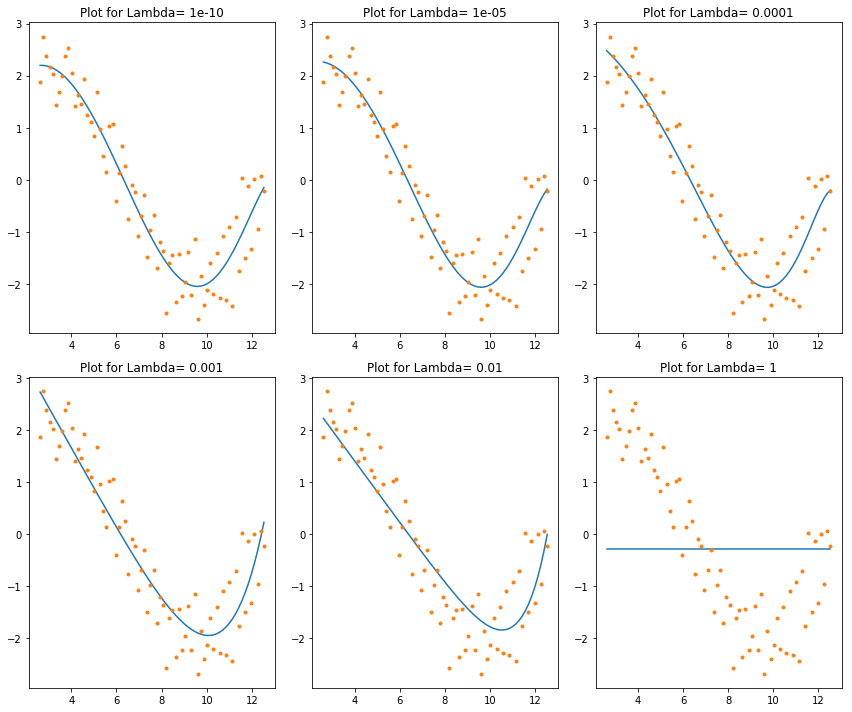

In [32]:
#Initialize predictors to all 15 powers of x
predictors=['x']
predictors.extend(['x^%d'%i for i in range(2,16)])

#Define the lambda values to test
lambda_lasso = [1e-15, 1e-10, 1e-8, 1e-5,1e-4, 1e-3,1e-2, 1, 5, 10]

#Initialize the dataframe to store coefficients
col = ['rss','intercept','coef_x'] + ['coef_x^%d'%i for i in range(2,16)]
ind = ['lambda_%.2g'%lambda_lasso[i] for i in range(0,10)]
coef_matrix_lasso = pd.DataFrame(index=ind, columns=col)

#Define the models to plot
models_to_plot = {1e-10:231, 1e-5:232,1e-4:233, 1e-3:234, 1e-2:235, 1:236}

#Iterate over the 10 lambda values:
for i in range(10):
    coef_matrix_lasso.iloc[i,] = lasso_regression(data, predictors, lambda_lasso[i], models_to_plot)

In [33]:
#Set the display format to be scientific for ease of analysis
pd.options.display.float_format = '{:,.2g}'.format
coef_matrix_lasso

,rss,intercept,coef_x,coef_x^2,coef_x^3,coef_x^4,coef_x^5,coef_x^6,coef_x^7,coef_x^8,coef_x^9,coef_x^10,coef_x^11,coef_x^12,coef_x^13,coef_x^14,coef_x^15
lambda_1e-15,16,0.48,1.3,-0.26,0.001,0.00055,3.6e-05,1.2e-06,-3.3e-09,-4.2e-09,-3.8e-10,-2.2e-11,-7.2e-13,8.1e-15,3e-15,1.6e-16,-1.4e-17
lambda_1e-10,16,0.48,1.3,-0.26,0.001,0.00055,3.6e-05,1.2e-06,-3.3e-09,-4.2e-09,-3.8e-10,-2.2e-11,-7.2e-13,8.1e-15,3e-15,1.6e-16,-1.4e-17
lambda_1e-08,16,0.48,1.3,-0.26,0.001,0.00055,3.6e-05,1.2e-06,-3.5e-09,-4.2e-09,-3.8e-10,-2.2e-11,-7.2e-13,8e-15,2.9e-15,1.5e-16,-1.3e-17
lambda_1e-05,17,1.3,0.86,-0.18,-0,0,6.9e-05,1.8e-07,0,-0,-0,-5.2e-12,-3.8e-12,-0,-0,0,0
lambda_0.0001,17,3,0,-0.08,-0,-0,0,1.9e-06,1.2e-07,0,0,0,0,-0,-0,-0,-1.2e-16
lambda_0.001,20,4.8,-0.78,-0,-0,0,0,0,9.8e-08,7.3e-10,0,0,0,0,-0,-0,-0
lambda_0.01,26,3.8,-0.59,-0,-0,0,0,0,0,0,0,2.8e-11,7.7e-13,0,0,0,0
lambda_1,1.7e+02,-0.28,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0
lambda_5,1.7e+02,-0.28,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0
lambda_10,1.7e+02,-0.28,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0


### Again, the models above appear smoother than without the regularization.  
This is due to them having far fewer nonzero weights. We can see in the table there are many zero entries. That's the result of this sparsity regularization.  

Of course, LASSO doesn't just send some weights to zero.  It penalizes the total weight, so even with just a small amount of regularization, when no wieghts are sent to zero, they're still smaller than with no regularization.

## Run the code block below to see exactly how many of the weights (out of 15 total) have become zero for each choice of $\lambda$ as a LASSO regularization weight.

In [34]:
coef_matrix_lasso.apply(lambda x: sum(x.values==0),axis=1)

lambda_1e-15      0
lambda_1e-10      0
lambda_1e-08      0
lambda_1e-05      9
lambda_0.0001    11
lambda_0.001     12
lambda_0.01      12
lambda_1         15
lambda_5         15
lambda_10        15
dtype: int64

# Recap
This isn't the end of the story. We can combine the two kinds of regularization we talked about (This is called Elastic net regularization). We can define arbitrary new ones.  
## For almost any prioperty you want your model to have, you can tack on a regularizer to help achieve it
Just tack a term onto your objective function that's big when that property is violated and small when the property is satisfied.  then by optimizing the new objective, we get a model that does a better job of satisfying the property.

The two examples we gave here of desirable properties are
- small model weights (regularize with squared weights) and
- sparsity (regularize with absolute value of weights),
but we can design regularizers that do all sorts of things. For example, we can use different lambda on different model weights to penalize particular parameters for violating certain properties, but not other parameters.

## Different kinds of error
In addition, we only really looked at one way of characterizing our errors.  We can instead weight errors such that e.g. false positives carry more weight than false negatives.
Optimizing with respect to that will find a model that especially won't make mistakes leading to false positives, but might make more false negative type mistakes. And vice/versa.

The possibilities for designing models around particular properties are virtually endless.
Hopefully this was helpful.
Some of the code used in this notebook was adapted from https://www.analyticsvidhya.com/blog/2016/01/complete-tutorial-ridge-lasso-regression-python/
A real data example:https://searchengineland.com/heres-how-i-used-python-to-build-a-regression-model-using-an-e-commerce-dataset-326493